Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [x] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Continue to participate in our Kaggle challenge. 
- [x] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [6]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/'

In [7]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Wrangle Data

In [8]:
def wrangle(fm_path, tv_path = None):
    # Import CSV files
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                   na_values = [0, -2.000000e-08],
                                   parse_dates = ['construction_year', 'date_recorded']),
                       pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], 
                     parse_dates = ['construction_year', 'date_recorded']).set_index('id')
    
    # Feature engineering (Credit: Mena)
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year
    
    # Drop constant and repeated columns
    df.drop(columns = ['recorded_by', 'extraction_type_group', 'extraction_type_class',
                       'quantity_group','date_recorded', 'construction_year', 'payment',
                       'source', 'waterpoint_type_group', 'scheme_management'], 
            inplace=True)
    
    # Drop columns with high % of NaN values
    df.dropna(axis = 1, thresh = len(df) * 0.65, inplace = True)
    
    # Columns where zeroes should be null values (Credit: Samuel E)
    cols_w_0s = ['longitude', 'latitude', 'gps_height']
    for col in cols_w_0s:
        df[col] = df[col].replace(0, np.nan)
    
    return df

In [9]:
# Read train_features.csv & train_labels.csv into single df
train = wrangle(fm_path = DATA_PATH+'waterpumps/train_features.csv',
                tv_path = DATA_PATH+'waterpumps/train_labels.csv')
train.head()

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,...,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
69572.0,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,...,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe,functional,12.0
8776.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,...,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,3.0
34310.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,...,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional,4.0
67743.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,...,user-group,never pay,soft,good,dry,borehole,groundwater,communal standpipe multiple,non functional,27.0
19728.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,...,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,NaN


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   funder            54987 non-null  object 
 1   gps_height        38962 non-null  float64
 2   installer         54967 non-null  object 
 3   longitude         57587 non-null  float64
 4   latitude          57587 non-null  float64
 5   wpt_name          59399 non-null  object 
 6   basin             59399 non-null  object 
 7   subvillage        59028 non-null  object 
 8   region            59399 non-null  object 
 9   region_code       59399 non-null  int64  
 10  district_code     59376 non-null  float64
 11  lga               59399 non-null  object 
 12  ward              59399 non-null  object 
 13  public_meeting    56066 non-null  object 
 14  permit            56343 non-null  object 
 15  extraction_type   59399 non-null  object 
 16  management        59399 non-nu

## Split Data

In [10]:
# Split data into feature matrix and target vector
target = 'status_group'
y_train = train[target]
X_train = train.drop(columns = target)

## Establish Baseline

In [11]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.5430899510092763


## Build Model

In [46]:
rf_model = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(random_state = 42,
                                                n_estimators = 277,
                                                max_depth = 35,
                                                max_samples = 0.5,
                                                max_features = 4,
                                                n_jobs = -1))

rf_model.fit(X_train, y_train);

**Check Scores**

In [47]:
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, n_jobs = -1)

print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.81557239 0.80892256 0.81321549 0.80875421 0.80697028]
Mean CV accuracy score: 0.8106869860317121
STD CV accuracy score: 0.0031913385315627905


## Tune Model

In [9]:
# Setting up estimator
estimator = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          RandomForestClassifier(random_state = 42))

# Want to find best simpleimputer strategy and best randomforestclassifier n_estimators & max_samples
params = {'simpleimputer__strategy': ['mean', 'median'],
          'randomforestclassifier__n_estimators': range(25, 125, 25),
          'randomforestclassifier__max_samples': np.arange(0.2, 1, 0.1)}

# Run GridSearchCV
model_gs = GridSearchCV(estimator, 
                        param_grid = params,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)

# Fit GridSearchCV to data
model_gs.fit(X_train, y_train);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_samples': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'randomforestclassifier__n_estimators': range(25, 125, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [17]:
model_gs.best_params_

{'randomforestclassifier__max_samples': 0.5000000000000001,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [18]:
model_gs.best_score_

0.805922652174862

In [14]:
# Set up a second estimator, that now includes the best hyperparameters from previous estimator
estimator2 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          RandomForestClassifier(random_state = 42,
                                                 max_samples = 0.5))

# Want to find best randomforestclassifier n_estimators
params2 = {'randomforestclassifier__n_estimators': range(2, 350, 25)}

# Run GridSearchCV
model2_gs = GridSearchCV(estimator2, 
                        param_grid = params2,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)

# Fit gridsearch to data
model2_gs.fit(X_train, y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [19]:
model2_gs.best_params_

{'randomforestclassifier__n_estimators': 277}

In [20]:
model2_gs.best_score_

0.8068822353795836

**Keep tuning, but now using `RandomizedSearchCV`**

In [1]:
# Set up a third estimator, that now includes the best hyperparameters from previous estimators
estimator3 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          RandomForestClassifier(random_state = 42,
                                                 max_samples = 0.5,
                                                 n_estimators = 277))

# Want to find best randomforestclassifier max_features
params3 = {'randomforestclassifier__max_features': range(2, 32, 2)}

# Run RandomizedSearchCV
model3_rs = RandomizedSearchCV(estimator3, 
                               param_distributions = params3,
                               n_iter = 5,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)

# Fit randomizedsearch to data
model3_rs.fit(X_train, y_train);

NameError: name 'make_pipeline' is not defined

In [28]:
model3_rs.best_params_

{'randomforestclassifier__max_features': 4}

In [30]:
model3_rs.best_score_

0.8070169353551794

In [43]:
# Set up a fourth estimator, that now includes the best hyperparameters from previous estimators
estimator3 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          RandomForestClassifier(random_state = 42,
                                                 max_samples = 0.5,
                                                 n_estimators = 277))

# Want to find best randomforestclassifier min_samples_split
params4 = {'randomforestclassifier__max_depth': range(10, 45, 5)}

# Run RandomizedSearchCV
model4_rs = RandomizedSearchCV(estimator3, 
                               param_distributions = params4,
                               n_iter = 5,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)

# Fit randomizedsearch to data
model4_rs.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [44]:
model4_rs.best_params_

{'randomforestclassifier__max_depth': 35}

In [45]:
model4_rs.best_score_

0.8072694549388716

## Make Submission

In [49]:
# Read test_features.csv 
test = wrangle(DATA_PATH+'waterpumps/test_features.csv')

# Make predictions on test data
y_pred = rf_model.predict(test)

# Put predictions in necessary format for submission to Kaggle
submission = pd.DataFrame({'status_group':y_pred}, index = test.index)

# Save csv with predictions in proper format
submission.to_csv('02_17_2021_submission.csv')

## Communicate Results

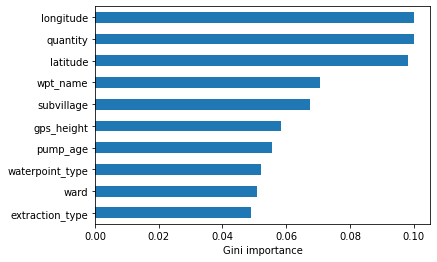

In [50]:
# Get importance of each feature
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_

# Get names of each feature
features = X_train.columns

# Make a series that combines the importance features and their names
feat_imp = pd.Series(importances, index = features).sort_values()

# Visualize the importances
feat_imp.tail(10).plot(kind = 'barh')
plt.xlabel('Gini importance');